# STEP 1
#### Choose which dataset to use here

In [58]:
"""
Load the dataset
"""

import numpy as np

data = np.loadtxt('wifi_db/clean_dataset.txt')
# data = np.loadtxt('wifi_db/noisy_dataset.txt')

# STEP 2

In [59]:
def entropy(dataset):
    """
    Calculate the entropy of the class distribution in a dataset.

    Arguments:
        dataset (np.ndarray): A 2D numpy array where each row represents a data 
                              sample, and the last column contains the class 
                              labels.

    Returns:
        numpy.float64: The entropy of the class distribution in the dataset.
    """
    
    _, counts = np.unique(dataset[:,-1], return_counts=True)
    ps = counts / dataset.shape[0]

    return -np.sum(ps * np.log2(ps))

In [60]:
def remainder(s_left, s_right):
    """
    Computes the remainder (weighted entropy) for a potential split in a 
    dataset during decision tree construction. 
    
    This is used to evaluate the quality of the split by calculating the 
    entropy on both sides of the split.

    Arguments:
        s_left (np.ndarray): A 2D numpy array representing the left subset,
                             where each row represents a data sample, and the 
                             last column contains the class labels.
        s_right (np.ndarray): A 2D numpy array representing the right subset,
                              with the same structure as s_left.

    Returns:
        numpy.float64: The weighted entropy remainder of the two subsets.
    """

    # Calculate the number of samples in each subset
    n_left = s_left.shape[0]
    n_right = s_right.shape[0]

    return (n_left * entropy(s_left) + n_right * entropy(s_right)) / (n_left + n_right)

In [61]:
def info_gain(all, left, right):
    """
    Computes the information gain from a potential split in the dataset during 
    decision tree construction.

    Args:
        all (np.ndarray): A 2D numpy array representing the entire dataset 
                          before splitting, where each row is a sample, and the 
                          last column contains class labels.
        left (np.ndarray): A 2D numpy array representing the left subset 
                           resulting from the split, with the same structure as 
                           all.
        right (np.ndarray): A 2D numpy array representing the right subset 
                            resulting from the split, with the same structure as 
                            all.

    Returns:
        numpy.float64: The information gain resulting from the split, calculated
                       as the difference between the entropy of the entire 
                       dataset and the weighted entropy of the split subsets.
    """
    
    return entropy(all) - remainder(left, right)

In [62]:
def find_split(dataset):
    """   
    Find the optimal feature and threshold to split a dataset by maximizing 
    information gain.

    This function iterates over each feature in the dataset, evaluates all 
    relevant split points (label changes), and calculates the information gain 
    for each split. The split that maximizes information gain is selected as the
    optimal split.

    Args:
        dataset (np.ndarray): A 2D numpy array where each row represents a data 
                              sample. The last column contains the class labels,
                              and all other columns are features.

    Returns:
        dict: A dictionary with the following keys:
              - 'feature' (int): Index of the feature that yields the optimal split.
              - 'threshold' (numpy.float64): Threshold value for the optimal split in the selected feature.
              - 'left' (np.ndarray): Subset of the dataset for samples less than to the threshold.
              - 'right' (np.ndarray): Subset of the dataset for samples greater than or equal to the threshold.
    
    """

    num_features = dataset[:, :-1].shape[1]

    max_feature = -1
    max_gain = -1
    max_left = -1
    max_right = -1
    for feature in range(num_features):
        # Sort the data on the specified feature
        sorted_data = dataset[dataset[:, feature].argsort()]
        features = sorted_data[:, :-1]
        labels = sorted_data[:, -1]

        # Iterate through the sorted data until have found a "split point"
        for point in range(len(features) - 1):
            if labels[point] == labels[point + 1]:
                continue

            left = sorted_data[:point + 1, :]
            right = sorted_data[point + 1:, :]
            
            # Calculate the information gain for this split
            curr_gain = info_gain(sorted_data, left, right)
         
            # If this is the best split so far, update the best split
            if curr_gain > max_gain:
                max_gain = curr_gain
                max_feature = feature
                max_left = left
                max_right = right


    return {'feature': max_feature, 'threshold': max_right[0, max_feature], 'left': max_left, 'right': max_right}

type(find_split(data)['left'])


numpy.ndarray

In [63]:
def decision_tree_learning(dataset, depth=1):
    """
    Recursively construct a decision tree using a dataset by maximizing information gain at each split.

    Builds a binary decision tree by recursively finding the optimal feature 
    and threshold to split the dataset. The process continues until all samples in a node 
    have the same class label or no further informative splits are possible. The function 
    returns a dictionary representation of the tree and its maximum depth (for visualisation).

    Args:
        dataset (np.ndarray): A 2D numpy array where each row is a data sample. 
                              The last column contains class labels, and all 
                              other columns are features.
        depth (int): The current depth of the tree during recursion (default is 1).

    Returns:
        tuple: A tuple containing:
               - node (dict): A dictionary representing the decision node or leaf. 
                 - If a leaf, contains {'value': label}.
                 - If a decision node, contains:
                   - 'feature' (int): Index of the feature for the split.
                   - 'value' (numpy.float64): Threshold value for the split.
                   - 'left' (dict): Left subtree (samples < threshold).
                   - 'right' (dict): Right subtree (samples >= threshold).
               - max_depth (int): The maximum depth of the tree.
    """
    
    labels = dataset[:, -1]

    if len(np.unique(labels)) == 1:
        return {'value': labels[0]}, depth
            
    # Find the best split to maximise the information gain
    split = find_split(dataset)

    l_branch, l_depth = decision_tree_learning(split['left'], depth + 1)
    r_branch, r_depth = decision_tree_learning(split['right'], depth + 1)

    node = {'feature': split['feature'], 'value': split['threshold'], 'left': l_branch, 'right': r_branch}

    return node, max(l_depth, r_depth)

tree, depth = decision_tree_learning(data)

In [64]:
def layout(tree, depth) -> tuple[list, list]:
    """
    Determine the coordinates of nodes and arrows in a decision tree layout.

    This function traverses a decision tree to calculate the coordinates for each node 
    and the connecting arrows, producing a layout suitable for visualization. It assigns 
    positions to each node based on its depth and feature split and creates arrow 
    connections between parent and child nodes.

    Args:
        tree (dict): A dictionary representing the decision tree. Each node contains 
                     either {'feature', 'value', 'left', 'right'} for decision nodes 
                     or {'value'} for leaf nodes.
        depth (int): The maximum depth of the tree, used to calculate horizontal offsets 
                     for layout purposes.

    Returns:
        tuple: A tuple containing:
               - points (list): A list of tuples representing each node's coordinates 
                 and attributes, formatted as (x, y, feature, value), where 'feature' 
                 is the feature index (or None for leaves), and 'value' is the split 
                 value (or class label for leaves).
               - arrows (list): A list of tuples representing each arrow's start and 
                 end coordinates, formatted as ((x1, y1), (x2, y2)).
    """
    
    points = [] # [(x, y, feature, value)]
    arrows = [] # [((x1, y1), (x2, y2))]

    def dfs(tree, x, y):
        if not tree:
            return
        
        if not 'left' in tree and not 'right' in tree:
            points.append((x, y, None, tree['value'] ))
            return
        
        points.append((x, y, tree['feature'], tree['value']))
        offset_x = 2 ** (depth - y - 2)
        
        # Calculate the x coordinates of the left and right children
        left_x = x - offset_x
        right_x = x + offset_x

        arrows.append(((x, y), (left_x, y + 1)))
        arrows.append(((x, y), (right_x, y + 1)))

        dfs(tree['left'], left_x, y + 1)
        dfs(tree['right'], right_x, y + 1)

    dfs(tree, 2**(depth - 1) - 1, 0)

    return points, arrows

points, arrows = layout(tree, depth)

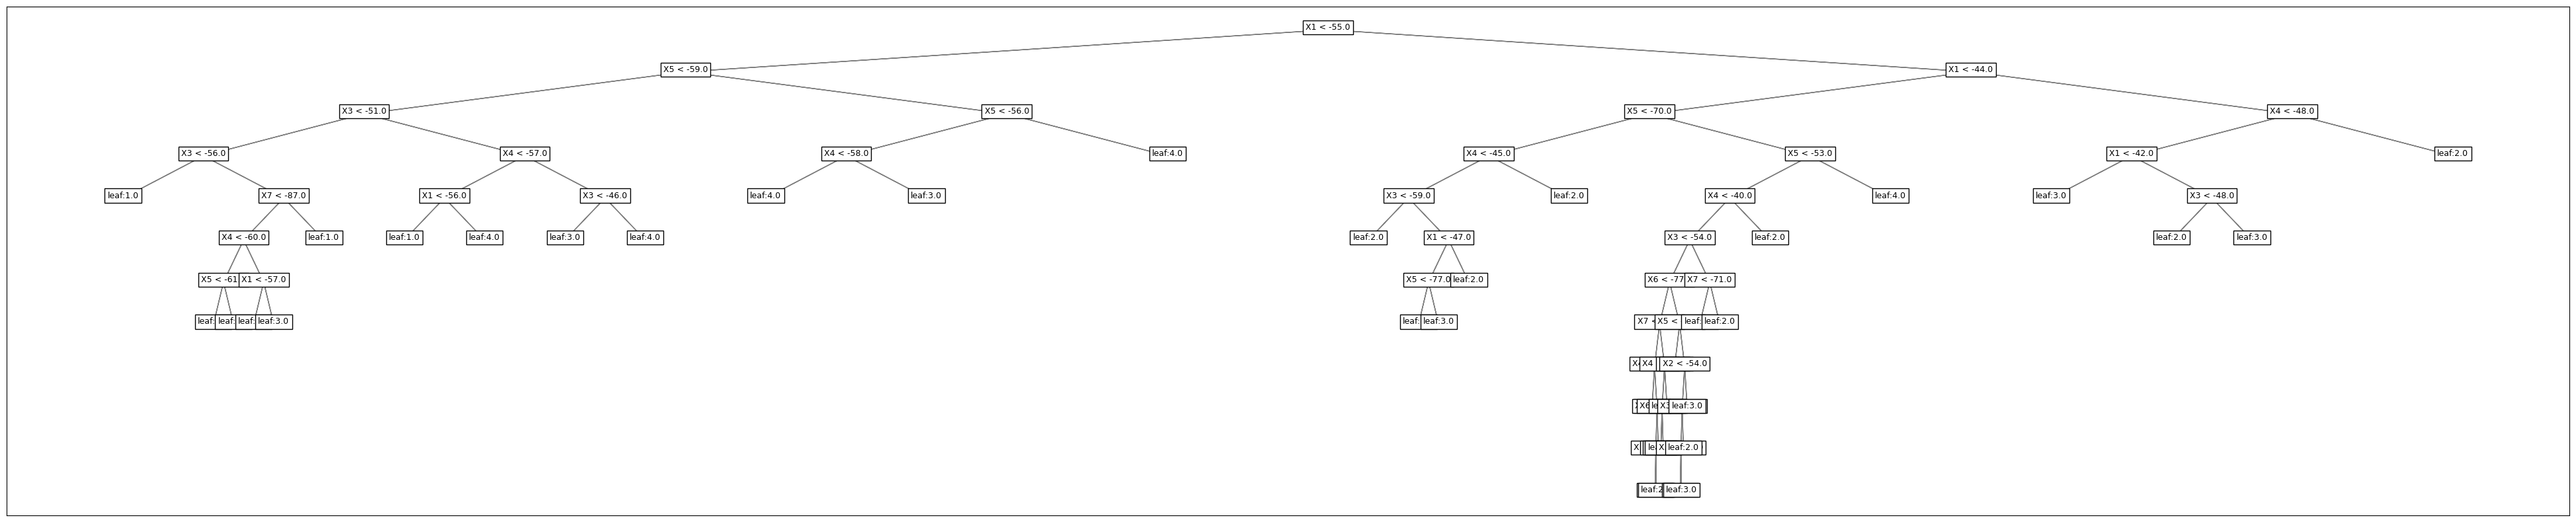

In [65]:
import matplotlib.pyplot as plt

def plot_nodes(x_coords, y_coords, features, values):
    """
    Plot the nodes of a decision tree with labels for each node.

    This function displays each node as a labeled box at its (x, y) coordinates. 
    If the node is a leaf, it displays the class label. For decision nodes, it 
    displays the feature and threshold used for the split.

    Args:
        x_coords (list[int]): X-coordinates of each node.
        y_coords (list[int]): Y-coordinates of each node.
        features (list[int | None]): Feature indices for each node (None for leaves).
        values (list[float | int]): Values to display in each node; either threshold 
                                    values for splits or class labels for leaves.
    """
    
    for i, value in enumerate(values):
        if features[i] is None:
            plt.text(
                x_coords[i], y_coords[i], f'leaf:{value}', 
                fontsize=9, ha='center', 
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3}
            )
        else:
            plt.text(
                x_coords[i], y_coords[i], f'X{features[i]+1} < {value}', 
                fontsize=9, ha='center', 
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3}
            )

def plot_arrows(arrows):
    """
    Draw arrows connecting nodes in a decision tree visualization.

    This function takes a list of start and end coordinates for each arrow and 
    draws them to represent connections between parent and child nodes in the tree.

    Args:
        arrows (list[tuple[tuple[int, int], tuple[int, int]]]): 
               List of tuples representing start and end coordinates for each arrow, 
               formatted as ((x_start, y_start), (x_end, y_end)).
    """

    for start, end in arrows:
        x_start, y_start = start[0], -start[1]
        x_end, y_end = end[0], -end[1]

        plt.arrow(
            x_start, y_start, x_end - x_start, y_end - y_start,
            head_width=0, head_length=0, fc='gray', ec='gray', 
            length_includes_head=True
        )

def draw_tree(nodes, arrows):
    """
    Render a full visualization of a decision tree.

    This function coordinates the plotting of nodes and arrows to display a 
    complete decision tree. It sets up a figure, processes node and arrow 
    data, and displays the tree layout.

    Args:
        nodes (list[tuple[int, int, int | None, float | int]]): List of tuples 
               representing each node's (x, y) coordinates, feature index (None for 
               leaves), and value (threshold for decision nodes, class label for leaves).
        arrows (list[tuple[tuple[int, int], tuple[int, int]]]): List of tuples 
               representing start and end coordinates for each arrow connecting nodes.
    """

    x_coords = [point[0] for point in nodes]
    y_coords = [-point[1] for point in nodes]
    features = [point[2] for point in nodes]
    values = [point[3] for point in nodes]

    plt.figure(figsize=(50, 10))
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)

    # Plot arrows and node labels
    plot_nodes(x_coords, y_coords, features, values)
    plot_arrows(arrows)
  
    plt.grid(True)
    plt.show()

draw_tree(points, arrows)

# STEP 3

In [66]:
def traverse_singular(tree, entry) -> int:
    """
    Traverse a decision tree to predict the class label for a single entry.

    This function recursively traverses the decision tree based on the features of 
    the provided entry. It follows the decision rules at each node until it reaches 
    a leaf node, which contains the predicted class label.

    Args:
        tree (dict): A dictionary representing the decision tree, where each node can 
                     be a decision node containing 'feature', 'value', 'left', and 
                     'right', or a leaf node containing 'value'.
        entry (numpy.ndarray): A list or array representing the feature values of the instance 
                               for which the prediction is to be made. The features must match 
                               the order of the tree's decision criteria.

    Returns:
        int: The predicted class label for the given entry.
    """

    if 'left' not in tree and 'right' not in tree:
        return tree['value']
    
    if entry[tree['feature']] < tree['value']:
        return traverse_singular(tree['left'], entry)
    
    return traverse_singular(tree['right'], entry)

In [67]:
def confusion_matrix_for_fold(fold, tree):
    """
    Calculate the confusion matrix for a given fold of data using a decision tree.

    This function evaluates the performance of a decision tree model on a specific 
    fold of data (as in k-fold cross-validation) by generating a confusion matrix. 
    The confusion matrix is a 2D array that summarizes the counts of true positives, 
    false positives, true negatives, and false negatives for each class.

    Args:
        fold (numpy.ndarray): A 2D array of entries representing the test dataset for the 
                              current fold, where the last column of each entry is its 
                              class label and the rest are features.
        tree (dict): A dictionary representing the decision tree used for making 
                     predictions. The tree structure contains nodes with features and 
                     thresholds, as well as leaf nodes with predicted class labels.

    Returns:
        np.ndarray: A num_unique_labels x num_unique_labels confusion matrix 
                    where the entry at (i, j) indicates the number of instances 
                    from class (i + 1) that were predicted as class (j + 1).
    """  

    num_unique_labels = np.unique(data[:,-1]).shape[0]

    confusion_matrix = np.zeros((num_unique_labels, num_unique_labels), dtype=int)

    for entry in fold:
        predicted = traverse_singular(tree, entry)
        actual = entry[-1]

        confusion_matrix[int(actual - 1)][int(predicted - 1)] += 1

    return confusion_matrix

In [68]:
k_folds = 10

def confusion_matrix_for(data):
    """
    Compute the confusion matrix using k-fold cross-validation over the dataset.

    Implements k-fold cross-validation to evaluate the performance of 
    a decision tree classifier on the provided dataset. The data is split into k 
    subsets (folds), and for each fold, the function trains the decision tree on the 
    remaining folds and tests it on the current fold. The overall confusion matrix is 
    calculated by aggregating the results from each fold.

    Args:
        data (np.ndarray): A 2D array where each row represents an instance with 
                           features followed by the actual class label in the last column.

    Returns:
        np.ndarray: A confusion matrix of shape (num_unique_labels, num_unique_labels), 
                    where the entry at (i, j) indicates the number of instances from class 
                    (i + 1) that were predicted as class (j + 1).
    """

    # Split the data into k folds
    np.random.shuffle(data)

    split_size = len(data) // k_folds
    num_unique_labels = np.unique(data[:,-1]).shape[0]

    # Initialise the main confusion matrix
    confusion_matrix = np.zeros((num_unique_labels,num_unique_labels), dtype=int)

    for i in range(k_folds):
        # Split the data into training and testing sets
        left = data[:i * split_size]
        test = data[i * split_size: (i+1) * split_size]
        right = data[(i+1) * split_size + k_folds:]

        # Build the decision tree on the training set
        train = np.concatenate((left, right), axis=0)
        tree, _ = decision_tree_learning(train)

        # Compute the confusion matrix for this fold and add it to the main one
        cm = confusion_matrix_for_fold(test, tree)
        confusion_matrix += cm

    return confusion_matrix

confusion_matrix = confusion_matrix_for(data)
print(f'Confusion matrix:\n {confusion_matrix}')

Confusion matrix:
 [[491   0   4   5]
 [  0 481  19   0]
 [  2  23 472   3]
 [  4   0   2 494]]


In [69]:
def evaluate(confusion_matrix):
    """
    Calculate the accuracy of a model based on the confusion matrix.

    This function computes the accuracy of a classification model by evaluating the 
    given confusion matrix. Accuracy is defined as the ratio of correctly predicted 
    instances to the total number of instances.

    Args:
        confusion_matrix (np.ndarray): A 2D array representing the confusion 
                                        matrix, where the entry at (i, j) indicates 
                                        the number of instances from class (i + 1) that 
                                        were predicted as class (j + 1).

    Returns:
        float: The accuracy of the model, represented as a value between 0 and 1, 
               where 1 indicates perfect accuracy.
    """
    
    total = np.sum(confusion_matrix)
    correct = np.sum(np.diagonal(confusion_matrix))

    return float(correct / total)

print(f'Accuracy: {evaluate(confusion_matrix)}')

Accuracy: 0.969


In [70]:
def precision_for_label(label, confusion_matrix):
    """
    Calculate the precision for a specific class label based on the confusion matrix.

    Precision is defined as the ratio of true positive predictions to the total number of 
    positive predictions (true positives + false positives) for the given class label. 

    Args:
        label (int): The class label for which to calculate precision. It should be a 
                     positive integer corresponding to the class index.
        confusion_matrix (np.ndarray): A 2D array representing the confusion 
                                        matrix, where the entry at (i, j) indicates 
                                        the number of instances from class (i + 1) that 
                                        were predicted as class (j + 1).

    Returns:
        float: The precision for the specified class label, represented as a value between 0 
               and 1, where 1 indicates perfect precision.
    """

    tp = confusion_matrix[label - 1][label - 1]
    fp = 0
    for i in range(confusion_matrix.shape[0]):
        if i+1 == label:
            continue
        fp += confusion_matrix[i][label - 1]

    return float(tp / (tp + fp))

for i in range(4):
    print(f'Precision for X{i+1}: {precision_for_label(i+1, confusion_matrix)}')

Precision for X1: 0.9879275653923542
Precision for X2: 0.9543650793650794
Precision for X3: 0.9496981891348089
Precision for X4: 0.9840637450199203


In [71]:
def recall_for_label(label, confusion_matrix):
    """
    Calculate the recall for a specific class label based on the confusion matrix.

    Recall is defined as the ratio of true positive predictions to the total 
    number of actual positive instances for the given class label.

    Args:
        label (int): The class label for which to calculate recall. It should be a 
                     positive integer corresponding to the class index.
        confusion_matrix (np.ndarray): A 2D array representing the confusion 
                                        matrix, where the entry at (i, j) indicates 
                                        the number of instances from class (i + 1) that 
                                        were predicted as class (j + 1).

    Returns:
        float: The recall for the specified class label, represented as a value between 0 
               and 1, where 1 indicates perfect recall.
    """

    tp = confusion_matrix[label - 1][label - 1]
    fn = 0
    for i in range(confusion_matrix.shape[0]):
        if i+1 == label:
            continue
        fn += confusion_matrix[label - 1][i]

    return float(tp / (tp + fn))

for i in range(4):
    print(f'Recall for X{i+1}: {recall_for_label(i+1, confusion_matrix)}')

Recall for X1: 0.982
Recall for X2: 0.962
Recall for X3: 0.944
Recall for X4: 0.988


In [72]:
def f1_for_label(label, cm):
    """
    Calculate the F1 measure for a specific class label based on the confusion matrix.

    The F1 measure is the harmonic mean of precision and recall, providing a single metric 
    that balances both the concerns of false positives and false negatives.

    Args:
        label (int): The class label for which to calculate the F1 score. It should be a 
                     positive integer corresponding to the class index.
        cm (np.ndarray): A 2D array representing the confusion matrix, where the 
                         entry at (i, j) indicates the number of instances from class 
                         (i + 1) that were predicted as class (j + 1).

    Returns:
        float: The F1 score for the specified class label, represented as a value between 
               0 and 1, where 1 indicates perfect precision and recall.
    """

    p = precision_for_label(label, cm)
    r = recall_for_label(label, cm)
    return (2 * p * r) / (p + r)

for i in range(4):
    print(f'F1 measure for X{i+1}: {f1_for_label(i+1, confusion_matrix)}')

F1 measure for X1: 0.9849548645937813
F1 measure for X2: 0.9581673306772909
F1 measure for X3: 0.946840521564694
F1 measure for X4: 0.9860279441117764
